In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
from tqdm import tqdm
import os

# Constants
GRID_SIZE = 30
NUM_COLORS = 10
CONTEXT_LENGTH = 4
BATCH_SIZE = 16

# Import the GridTransformer model
from grid_transformer import GridTransformer

class ARCTestDataset(Dataset):
    def __init__(self, test_file):
        with open(test_file, 'r') as f:
            self.test_data = json.load(f)
        
        self.data = []
        self.task_ids = []
        for task_id, task in self.test_data.items():
            for test_pair in task['test']:
                input_sequence = self.preprocess_grid(test_pair['input'])
                while len(input_sequence) < CONTEXT_LENGTH:
                    input_sequence.insert(0, np.zeros((GRID_SIZE, GRID_SIZE), dtype=int))
                input_window = input_sequence[-CONTEXT_LENGTH:]
                self.data.append(input_window)
                self.task_ids.append(task_id)
    
    def preprocess_grid(self, grid):
        if isinstance(grid[0], list):  # If it's already a 2D grid
            return [self.preprocess_single_grid(grid)]
        else:  # If it's a sequence of grids
            return [self.preprocess_single_grid(g) for g in grid]
    
    def preprocess_single_grid(self, grid):
        padded_grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
        h, w = min(GRID_SIZE, len(grid)), min(GRID_SIZE, len(grid[0]))
        padded_grid[:h, :w] = np.array(grid)[:h, :w]
        return padded_grid
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long), self.task_ids[idx]

def generate_solutions(model, test_loader, device):
    model.eval()
    solutions = {}
    
    with torch.no_grad():
        for inputs, task_ids in tqdm(test_loader, desc="Generating solutions"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            predicted_grids = torch.argmax(outputs, dim=3).cpu().numpy()
            
            for pred_grid, task_id in zip(predicted_grids, task_ids):
                if task_id not in solutions:
                    solutions[task_id] = {"test": []}
                
                # Trim the grid to remove padding
                trimmed_grid = trim_grid(pred_grid)
                solutions[task_id]["test"].append({"output": trimmed_grid.tolist()})
    
    return solutions

def trim_grid(grid):
    non_zero_rows = np.any(grid != 0, axis=1)
    non_zero_cols = np.any(grid != 0, axis=0)
    row_indices = np.where(non_zero_rows)[0]
    col_indices = np.where(non_zero_cols)[0]
    if len(row_indices) == 0 or len(col_indices) == 0:
        return np.array([[0]])
    return grid[row_indices[0]:row_indices[-1]+1, col_indices[0]:col_indices[-1]+1]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the fine-tuned model
model = GridTransformer(num_layers=2, embed_dim=64, num_heads=4, ff_dim=256).to(device)
model.load_state_dict(torch.load("grid_transformer_finetuned.pth"))
model = model.to(device)

# Create dataset and dataloader for ARC test data
test_dataset = ARCTestDataset("data/arc-agi_test_challenges.json")
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Generate solutions
solutions = generate_solutions(model, test_loader, device)

# Save the solutions
with open("arc-agi_test_solutions.json", "w") as f:
    json.dump(solutions, f, indent=2)

print("Solutions generated and saved as arc-agi_test_solutions.json")


Using device: cuda


Generating solutions: 100%|██████████| 7/7 [00:00<00:00, 21.31it/s]

Solutions generated and saved as arc-agi_test_solutions.json


In [9]:
test_data = json.loads(open("data/arc-agi_test_challenges.json",'r').read())

In [ ]:
list(solutions.values())[0]

In [30]:
list(solutions.values())[0]

{'test': [{'output': [[7, 0, 7], [7, 0, 7], [7, 7, 0]]}]}

In [40]:
import matplotlib.pyplot as plt

def visualize_matrix(matrix_data):
    # Extract the output matrix
    output_matrix = matrix_data
    
    # Create a new figure
    plt.figure(figsize=(6, 6))
    
    # Display the matrix
    plt.imshow(output_matrix, cmap='tab10', vmin=0, vmax=9)
    
    # Remove axes
    plt.axis('off')
    
    # Add a title
    plt.title('Output Matrix')
    
    # Show the plot
    plt.show()


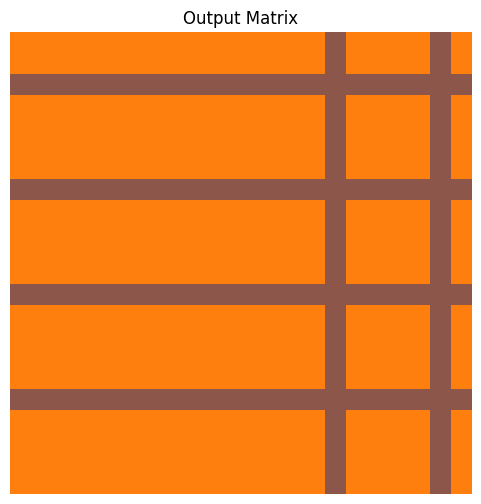

In [59]:
visualize_matrix(list(test_data.values())[20]['test'][0]['input'])